In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import timeit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import minimize
from itertools import product
from tqdm import tqdm

In [4]:
data = pd.read_csv("data/Electric_Production.csv")
data

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


In [5]:
X = data["DATE"]
y = data["Value"]
y

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Value, Length: 397, dtype: float64

# 1-4 


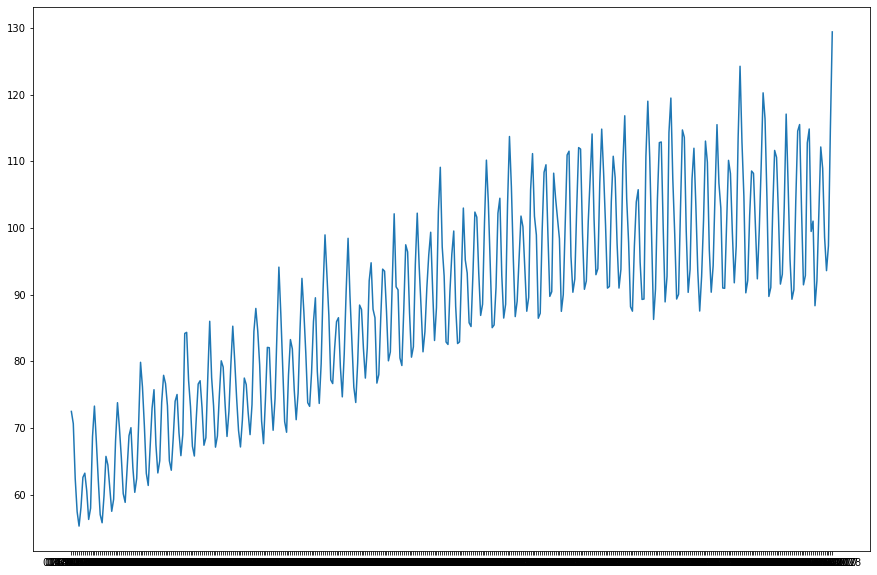

In [6]:
# ОБРАБОТКА ДАННЫХ 
# 1-4 
print("# 1-4 ")
plt.figure(figsize=(15, 10))
plt.plot(X, y)

In [5]:
#5 
print("# 5 #")

rolling_5 = y.rolling(4  # Size of the moving window
                         ).mean()
rolling_5

# 5 #


0             NaN
1             NaN
2             NaN
3       65.774700
4       61.477175
          ...    
392    105.463400
393    103.328525
394     99.624050
395    101.071550
396    108.768900
Name: Value, Length: 397, dtype: float64

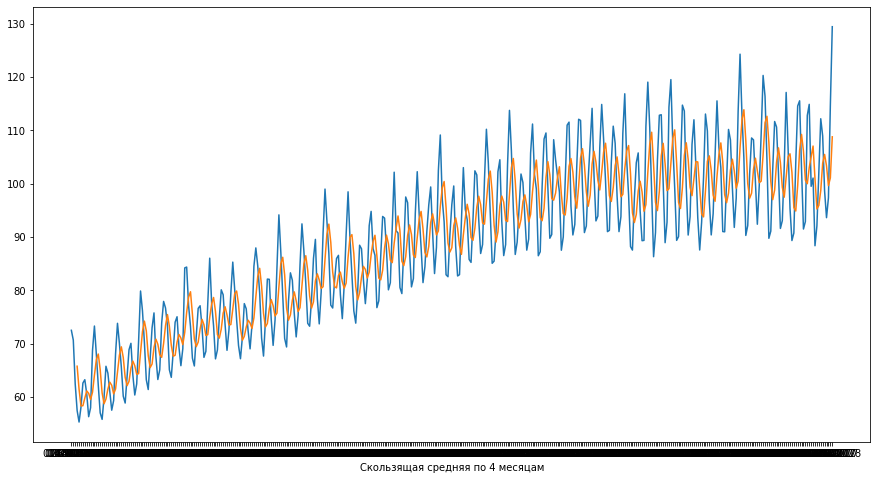

In [6]:
plt.plot(X, y)
plt.plot(X, rolling_5)
plt.xlabel('Скользящая средняя по 4 месяцам')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show();

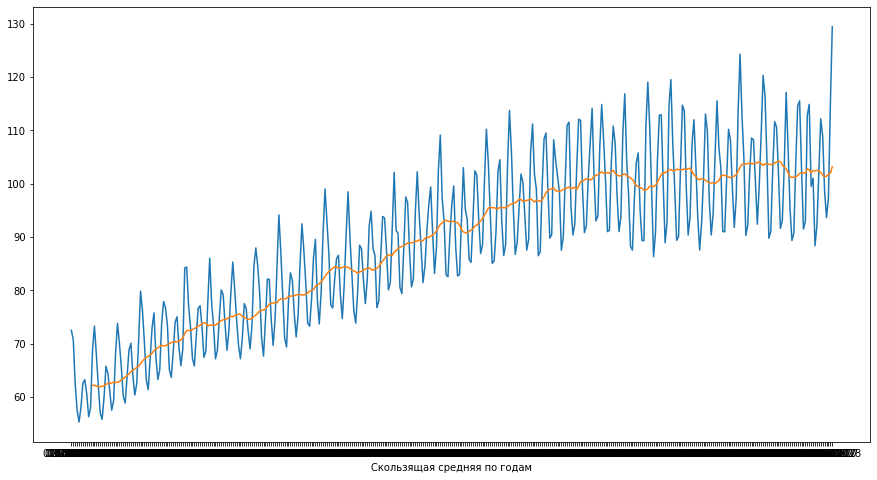

In [7]:
rolling_12 = y.rolling(12  # Size of the moving window
                          ).mean()
plt.plot(X, y)
plt.plot(X, rolling_12)
plt.xlabel('Скользящая средняя по годам')
fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.show();

In [14]:
print("# 6-7 #")


def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        plt.show()
    return

# 6-7 #


дифференцирование
Критерий Дики-Фуллера: p=0.000000


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


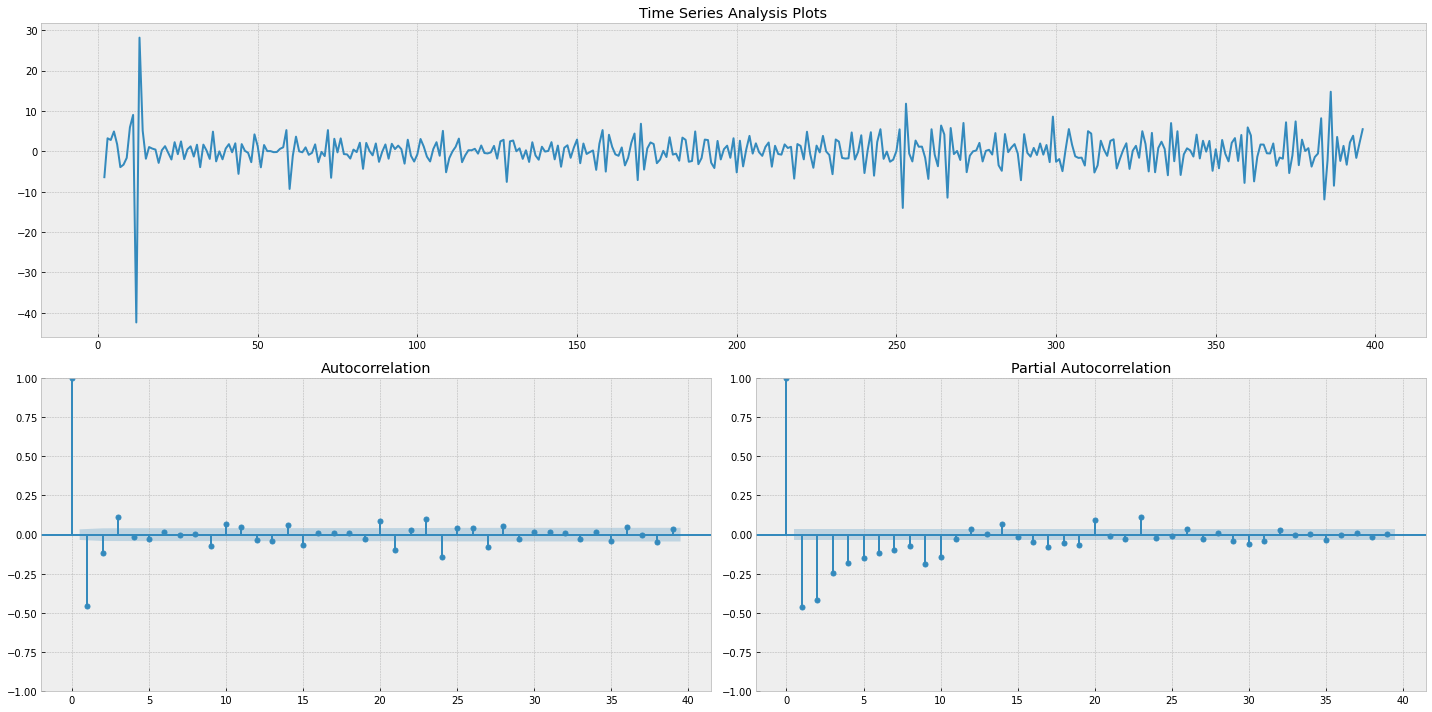

C:\Users\Asus\AppData\Local\Temp\ipykernel_13436\3291797108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolling_diff['Value'] = differencing['Value'].rolling(12  # Size of the moving window
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Критерий Дики-Фуллера: p=0.000000


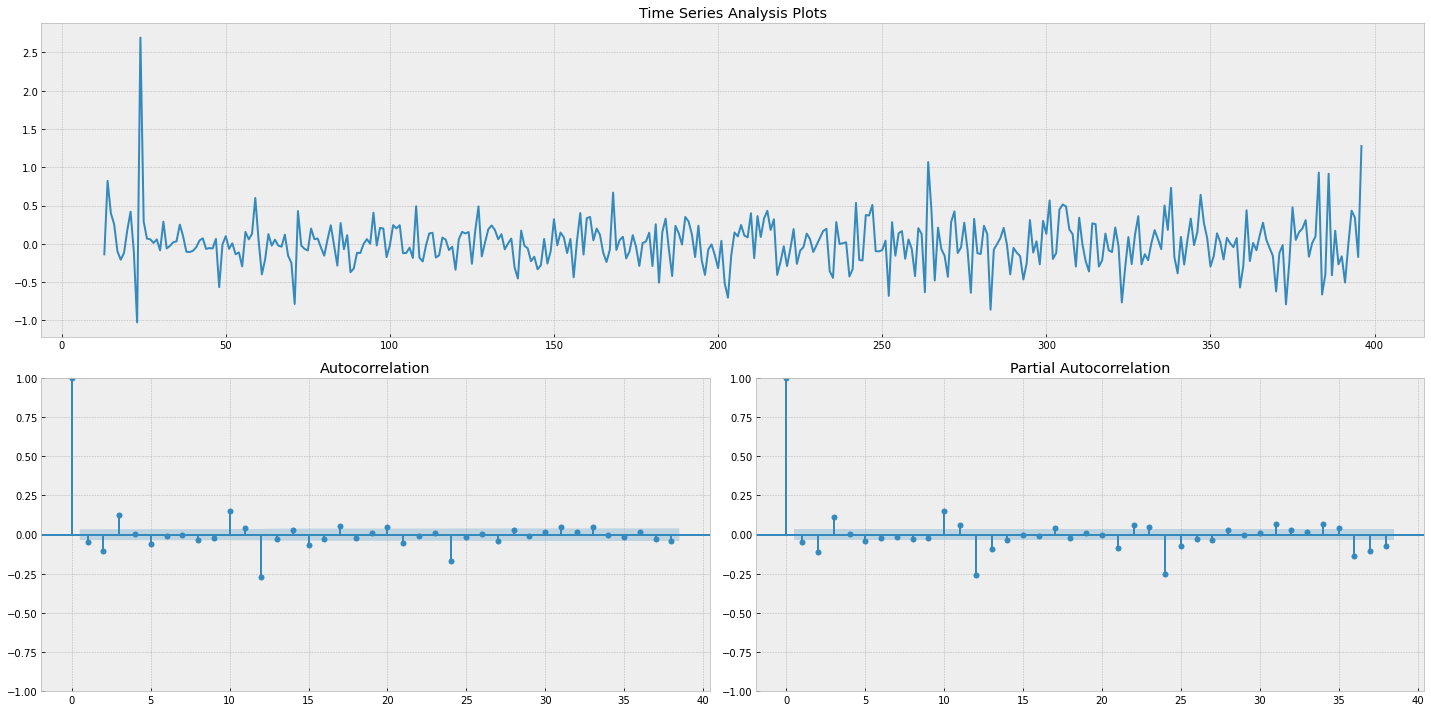

In [15]:
# дифференцирование
print("дифференцирование")
differencing = data
differencing['Value'] = data['Value'].diff().dropna()
differencing = differencing.dropna()
tsplot(differencing.Value,
       lags=data.Value.count() / 10)

# скользящее среднее по полученным данным
rolling_diff = differencing
rolling_diff['Value'] = differencing['Value'].rolling(12  # Size of the moving window
                                                      ).mean().dropna()
rolling_diff = rolling_diff.dropna()

tsplot(rolling_diff.Value,
       lags=rolling_diff.Value.count() / 10)

#ряд стацонарен и имеет явную сезонность

# 8 #


C:\Users\Asus\AppData\Local\Temp\ipykernel_13436\833796131.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yhat['Value'] = model_fit.predict(start=1, end=len(data.Value))


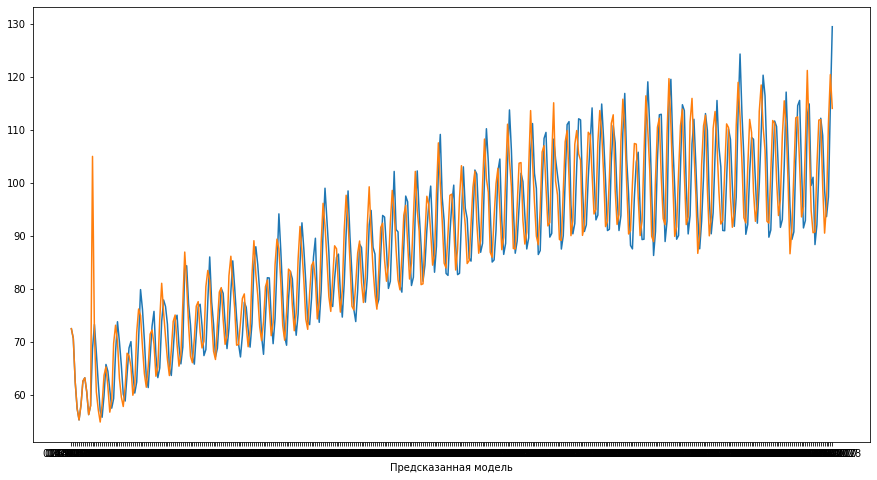

In [12]:
print("# 8 #")

# Построение модели временного ряда

# Для моделирования будем использовать модель SARIMA, построенную для ряда первых разностей.
# чтобы построить модель нам нужно знать ее порядок, состоящий из 3-х параметров:
# p — порядок компоненты AR
# d — порядок интегрированного ряда
# q — порядок компонетны MA

# Параметр d есть и он равет 1 (сколько раз было применено обычное дифференцирование),
# осталось определить p и q.
# Для их определения нам надо изучить авторкорреляционную(ACF)
# и частично автокорреляционную(PACF) функции для ряда первых разностей.

# ACF поможет нам определить q, т. к. по ее коррелограмме можно определить
# количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA

# PACF поможет нам определить p, т. к. по ее коррелограмме можно определить
# максимальный номер коэффициента сильно отличный от 0 в модели AR.

# Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf().
# Они выводят графики ACF и PACF,
# у которых по оси X откладываются номера лагов,
# а по оси Y значения соответствующих функций.
# лагов в функциях и определяет число значимых коэффициентов. Функции выводятся в 2 столбца по всей лабе

order = (1,  # p - порядок AR
         1,  # d - порядок интеграции процесса
         1  # q - порядок MA
         )
# тоже самое для сезонности
seasonal_order = (1,  # P - порядок AR
                  1,  # D - периодичность
                  1,  # Q - порядок MA
                  12  # s - количество периодов в сезоне
                  )

model = SARIMAX(endog=data.Value,
                order=order,
                seasonal_order=seasonal_order
                )
# заполняем модель данными
model_fit = model.fit()
# делаем предсказание моделью
yhat = data.Value
yhat['Value'] = model_fit.predict(start=1, end=len(data.Value))
#yhat['Value'] = model_fit.predict

plt.plot(X, data["Value"])
plt.plot(X, yhat.Value)
plt.xlabel('Предсказанная модель')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show();


Остатки


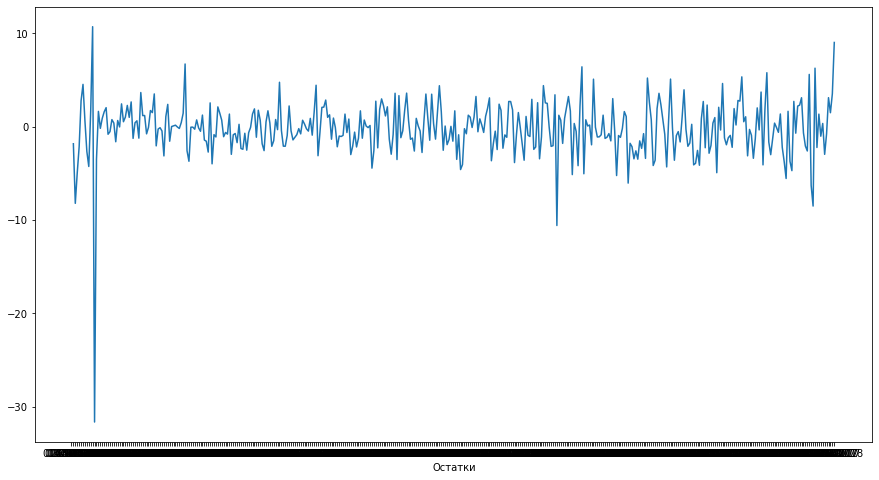

Среднее отклонение -0.23555781592692146


In [13]:

print("Остатки")
remainders = data
# чтобы индекс начинался с 1, а не с 0
# remainders.index = np.arange(1, len(remainders))
remainders["Value"] = remainders.Value - yhat.Value

plt.plot(X, remainders.Value)
plt.xlabel('Остатки')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show();

print("Среднее отклонение", remainders.Value.mean())